## Clustering

In [2]:

from collections import Counter
import math
import pprint
from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy import fftpack
from scipy.interpolate import CubicSpline
import time
import json
from fastdtw import fastdtw
import matplotlib.patches as mp

import warnings
warnings.filterwarnings('ignore')

### Global fun

In [18]:
def ComputeDtw_Matrix(mat,window=1): #Apply DTW to matrix. Return dissimilarity matrix
    res=np.zeros((mat.shape[0],mat.shape[0]))
    nb=res.shape[0]
    
    for i in range(nb):
        for j in range(i):
            res[i,j]=fastdtw(mat[i],mat[j],window)[0]
            
    return (res+res.T)

def ComputeCurveDerivate_Matrix(DF):#retourne la derivee des series temporelles
    r,c=DF.shape
    M_derivate=np.zeros((r,len(np.arange(1,c+1))))
    
    for i in range(0,r):
        cs=CubicSpline(np.arange(1,c+1),DF.values[i])
        M_derivate[i]=cs(np.arange(1,c+1),1)#derivee premiere 

    return pd.DataFrame(M_derivate,columns=np.arange(1,c+1),index=DF.index)

def ComputeDerivativeSpectrum_Matrix(DF): #retourne la matrice des spectres
    r,c=DF.shape
    spectre=np.zeros((r,c))
    
    for i,sensor in enumerate(DF.values):
        #Fast Fourier Transfo        
        spectre[i]=abs(np.fft.fft(sensor))
        
    return spectre


def get_indice_individus(clust):#renvoie la position des individus de chaque cluster
    return [list(np.where(clust==elem)[0]) for elem in np.sort(list(Counter(clust)))]

#def get_individus(clust,data):#renvoie les individus composants chaque cluster
#    return [data.iloc[list(np.where(clust==elem)[0])].values for elem in np.sort(list(Counter(clust)))]

def get_individus(clust, data):
    dic={}
    for i,classe in enumerate(clust):
        if str(classe) not in dic.keys():
            dic[str(classe)]=[]
        dic[str(classe)].append(data.index[i])

    return (dic) 
            
def read_conso_from_csv(file,sep='|'):# consommation to dataframe
    elec2=pd.read_csv(file,sep=sep)
    elec2.columns=["date","prm","puissance"]
    dates=list(elec2.date)
    vec=[x.replace(',','.') for x in elec2['puissance']]
    vec=[x.replace(' ','')for x in vec]

    elec2.puissance=[float(x) for x in vec]

    prm_unique=list(np.unique(elec2.prm))
    d_unique=list(np.unique(elec2.date))

    #check if there are missing dates
    res=[]

    #ordre de prm
    for elem in prm_unique:
        tmp=elec2[elec2['prm']==elem][['date','puissance']]
        dd={}
        for i,j in tmp.values:
            dd[i]=j
        res.append(dd)
    for i in range(len(res)):
        if len(res[i]) != len(d_unique):
            missing=np.setxor1d(dates,list(res[i].keys()))
            #intersection
            for j in missing:
                res[i][j]=0
    X= pd.DataFrame(res,index=prm_unique)
    X.columns=pd.to_datetime(X.columns)
    return(X)

def read_conso(file,sep='|'):
    cons=pd.read_csv(file,sep=sep,index_col=0)
    cons.columns=pd.to_datetime(cons.columns)
    return cons



def apply_clustering(data,k=2,critere="ward",window=1):
    
    #derivee    
    derivees=ComputeCurveDerivate_Matrix(data)

    #Fourier
    spectres=ComputeDerivativeSpectrum_Matrix(derivees)

    #DTW
    dist=ComputeDtw_Matrix(spectres,window)
    Z=linkage(dist,critere)
    clus=list(fcluster(Z,k,criterion="maxclust"))
    f=fcluster(Z,k,criterion="maxclust")
    
    return clus,Z,f


#colormap=np.array(['#B9648A','#16c72e','#1663c7','#c71f16',"#e8e230","#c76f16","#848484","#f49cc8","#e5d1fa","#5c0a33"])
colormap=np.array(['blue','#d10a3c','#6f7bbb','#3ac467','#c69942'])
                  
class Inerties():#calcul des inerties à partir des partitions
    def __init__(self,clusters):
        self.gi=np.array([e.mean(axis=0) for e in classes])
        self.g=self.gi.mean(axis=0)
        self.clusters=clusters
        
    def inter(self):
        #norm
        res=[len(self.clusters[i])*math.pow(np.linalg.norm(a-self.g),2) for i,a in enumerate(self.gi)]        
        res=np.sum(res)/len(self.gi)
        return res
    
    def total(self):
        cpt=0
        somme=0
        for c in classes:
            for ind in c:
                somme+=math.pow(np.linalg.norm(ind-self.g),2)        
            cpt+=1
        return somme/cpt         
        
    def intra(self):
        return(self.total()-self.inter())
    
def export_toPredict(prmID,DF):
    data=pd.DataFrame({'ds':DF.loc[prmID].index,'y':DF.loc[prmID]})
    data.to_csv("conso_prediction.csv",sep='|',header=True,index=False)
    print("saved in \'conso_prediction.csv\'")
    
def parse_json(input_file,output_file=None):
    file=json.load(open(input_file))
    buckets=file["aggregations"]["2"]["buckets"]
    
    res={}
    for elem in buckets:
        date=elem['key_as_string']
        tmp={}
        for i in range(len(elem["3"]["buckets"])):
            tmp[elem["3"]["buckets"][i]['key']]=elem["3"]["buckets"][i]['1']['value']
        res[date]=tmp
        
    conso=pd.DataFrame(res)
    conso.columns=pd.to_datetime(conso.columns,format='%d-%m-%Y %H:%M')
    conso.fillna(0,inplace=True)
    
    if output_file:
        conso.to_csv(output_file,sep='|',header=True,index=True)
        print("saved in \'"+output_file+"\'")
    
    return conso

### ELEC2

In [4]:
# raw CSV n*3
data2=read_conso_from_csv('ELEC-2Cluster_.csv',sep='|')

In [5]:
# Raw JSON
data=parse_json("elec_p10_2017_j.json",output_file=None)

In [6]:
# dfsfd
daily=read_conso("V9_1d.csv",sep='|')
hourly=read_conso("V9_1h.csv",sep='|')

In [10]:
print(data.shape)
print(daily.shape)

(77, 365)
(32, 365)


###  # application

temps d'exécution:  25.23293161392212 s


Text(0,0.5,'Conso(kwh)')

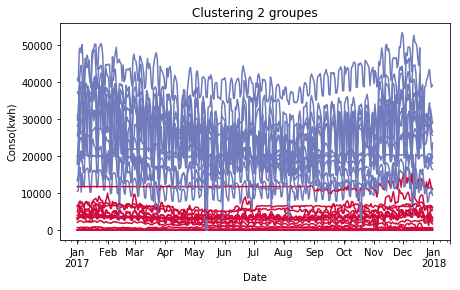

In [19]:
#days k=2
start=time.time()
cl2,z2,f2=apply_clustering(daily,k=2,window=2)
print("temps d'exécution: ",time.time()-start,'s')
classes=get_individus(cl2,daily)

#plot
daily.T.plot(legend=False,color=colormap[cl2] ,title='Clustering 2 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

In [20]:
classes

{'1': ['30000220752860',
  '30000230557351',
  '30000430156650',
  '30000930926205',
  '30001460609283',
  '30001460728202',
  '30001610739629',
  '30001611671143',
  '30001730103502',
  '30001770073385',
  '30002110409748',
  '30002110671537',
  '30002110834540',
  '30002410489198',
  '30002420209655',
  '30002420243082',
  '30002530133190',
  '30002541265825',
  '50053221028034'],
 '2': ['30001441036189',
  '30001460191130',
  '30001460609060',
  '30001480283067',
  '30001611021148',
  '30001770335839',
  '30001990221154',
  '30002130560854',
  '30002410490330',
  '30002520832570',
  '30002530781507',
  '30002530961946',
  'RTE0000516970']}

Text(0,0.5,'Conso(kW)')

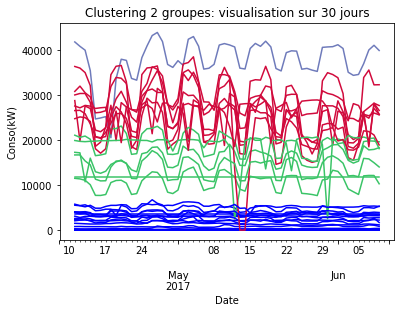

In [31]:
#ZOOM
daily.iloc[:,100:160].T.plot(legend=False,color=colormap[kmeans.labels_],title='Clustering 2 groupes: visualisation sur 30 jours')
plt.xlabel("Date")
plt.ylabel("Conso(kW)")

Text(0,0.5,'Conso(kW)')

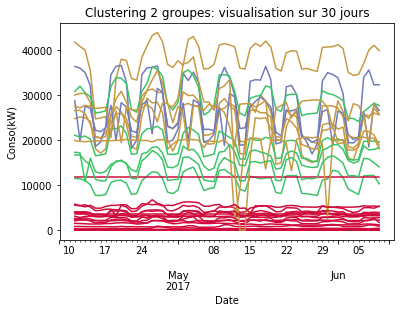

In [32]:
daily.iloc[:,100:160].T.plot(legend=False,color=colormap[cl2],title='Clustering 2 groupes: visualisation sur 30 jours')
plt.xlabel("Date")
plt.ylabel("Conso(kW)")

25.159664154052734


Text(0,0.5,'Conso(kwh)')

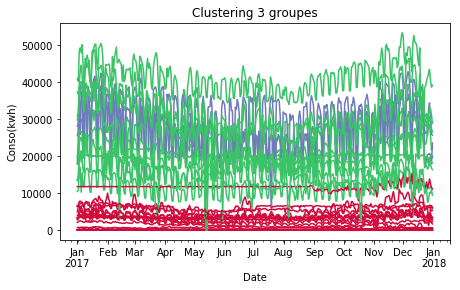

In [12]:
#days k=3
start=time.time()
cl3,z3,f3=apply_clustering(daily,k=3,window=2)
print(time.time()-start)

#plot
daily.T.plot(legend=False,color=colormap[cl3] ,title='Clustering 3 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

24.48004674911499


Text(0,0.5,'Conso(kwh)')

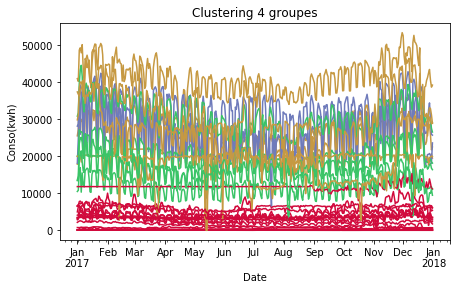

In [7]:
#days k=4
start=time.time()
cl4,z4,f4=apply_clustering(daily,k=4,window=2)
print(time.time()-start)

#plot
daily.T.plot(legend=False,color=colormap[cl4] ,title='Clustering 4 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

In [ ]:
#### Hourly data

827.8529825210571


Text(0,0.5,'Conso(kwh)')

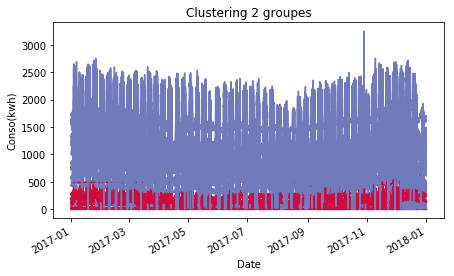

In [8]:
#Hourly k=2
start=time.time()
clh2,zh2,fh2=apply_clustering(hourly,k=2,window=2)
print(time.time()-start)

#plot
hourly.T.plot(legend=False,color=colormap[clh2] ,title='Clustering 2 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

825.1751096248627


Text(0,0.5,'Conso(kwh)')

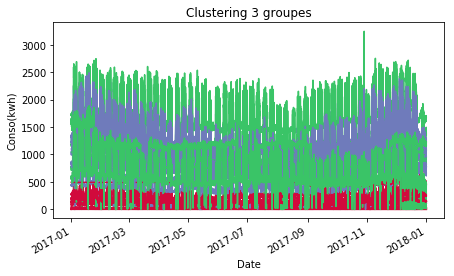

In [9]:
#Hourly k=3
start=time.time()
clh3,zh3,fh3=apply_clustering(hourly,k=3,window=2)
print(time.time()-start)

#plot
hourly.T.plot(legend=False,color=colormap[clh3] ,title='Clustering 3 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

827.9413197040558


Text(0,0.5,'Conso(kwh)')

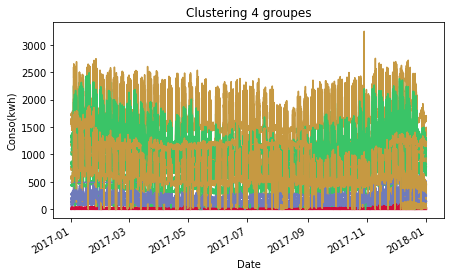

In [10]:
#Hourly k=4
start=time.time()
clh4,zh4,fh4=apply_clustering(hourly,k=4,window=2)
print(time.time()-start)

#plot
hourly.T.plot(legend=False,color=colormap[clh4] ,title='Clustering 4 groupes',figsize=(7,4))
plt.xlabel("Date")
plt.ylabel("Conso(kwh)")

Text(0,0.5,'Distance entre les clusters')

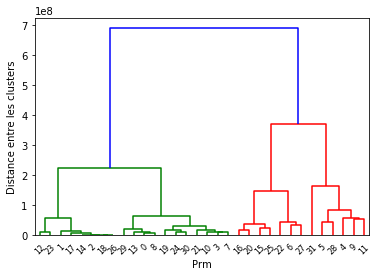

In [14]:
x=dendrogram(zh2,show_leaf_counts=False)
plt.xlabel("Prm")
plt.ylabel("Distance entre les clusters")

###  # mesures

In [6]:
classes=get_individus(cl,data)
indices=get_indice_individus(cl)
#Inertie des partitions
print("inertie_inter: {} \nInertie intra: {}".format(Inerties(classes).inter(),Inerties(classes).intra()))

inertie_inter: 113395626235.13794 
Inertie intra: 34826146667.236206


(150, 2)


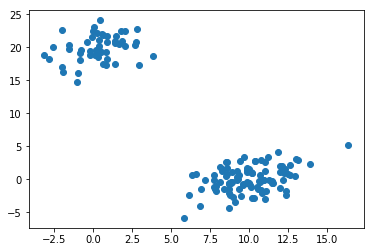

In [47]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print (X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])

In [55]:
Z=linkage(X,'ward')
c, coph_dists = cophenet(Z, pdist(X,'correlation'))
c

0.9979312241717571

[ 15.11533118  17.11527362  23.12198936 180.27043021]


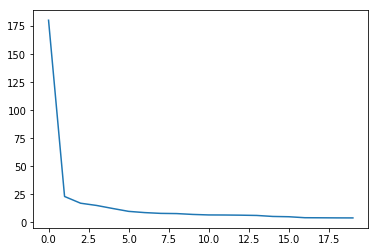

In [84]:
#[idx1, idx2, dist, sample_count]. indique une coupe à 25 pour avoir un bon clustering
plt.plot(sorted(Z[:,2],reverse=True)[:20])
print(Z[-4:,2])

#### Base/load 

In [53]:
def parse_file_arenh(input_file):
    file=json.load(open(input_file))
    buckets=file["aggregations"]["2"]["buckets"]
    
    res={}
    for elem in buckets:
        date=pd.to_datetime(elem['key'],unit='ms')
        res[date]=elem['3']['buckets'][0]['1']['value']

    return res


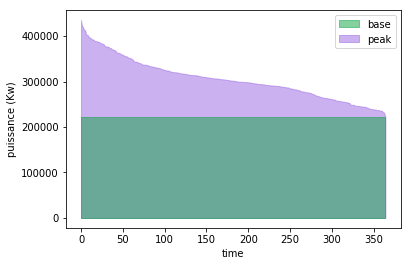

In [105]:
file=parse_file_arenh('dayday_kw.json')#data a la journée
#peak
plt.fill_between(np.arange(len(file.values())),np.sort(list(file.values()))[::-1],color='#9965E3',alpha=.5)
a=np.array(list(file.values()))

#base
min_value=min(a[a!=0])
plt.fill_between(np.arange(len(file.values())),np.repeat(min_value,len(file.values())),color='#0AA240',alpha=.5)
#arenh
res=

#plot
peak=mp.Patch(color='#9965E3',label='peak',alpha=.5)
base=mp.Patch(color='#0AA240',label='base',alpha=.5)
arenh=mp.Patch(color='#E8B426',label='base',alpha=.5)

plt.xlabel('time')
plt.ylabel('puissance (Kw)')
plt.legend(handles=[base,peak])

### Ecart type

In [100]:
tt=data.loc['30000230557351']
tt.values

array([308.333, 714.5  , 710.833, 641.667, 649.167, 653.667, 729.167,
       706.667, 761.667, 713.833, 757.167, 813.333, 796.833, 743.167,
       729.833, 703.167, 720.   , 689.5  , 720.   , 756.5  , 758.833,
       739.667, 748.167, 739.833, 742.5  , 755.167, 753.333, 725.5  ,
       713.667, 738.667, 746.   , 712.5  , 747.833, 693.5  , 696.167,
       697.5  , 689.833, 689.833, 733.667, 727.   , 726.333, 694.833,
       679.833, 720.667, 680.167, 701.167, 681.   ,  27.667])

In [ ]:
#plot standard deviation
tt=data.loc['30000230557351']

echantillon=tt.values
past=10
error=[0]*past
for i in range(past,len(echantillon)):
    error.append(np.std(echantillon[i-past:i]))

plt.figure(figsize=(14,8))   
plt.errorbar(tt.index,echantillon,error,linestyle='solid',fmt='-o')
plt.title("Standard deviation")
plt.xlabel("date")
plt.ylabel('Puissance KWh')